In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import imdb

### Classifying movie reviews: a binary classification example

Two-class classification, or binary classification, is one of the most common kinds of machine-learning problem. In this example, you’ll learn to classify movie reviews as positive or negative, based on the text content of the reviews.

IMDB dataset: a set of 50,000 highly polarized reviews from the Internet Movie Database. They’re split into 25,000 reviews for training and 25,000 reviews for testing, each set consisting of 50% negative and 50% positive reviews.

Just like the MNIST dataset, the IMDB dataset comes packaged with Keras. It has already been preprocessed: the reviews (sequences of words) have been turned into sequences of integers, where each integer stands for a specific word in a dictionary. This enables us to focus on model building, training, and evaluation.



In [2]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

The argument num_words=10000 means you’ll only keep the top 10,000 most frequently occurring words in the training data. Rare words will be discarded. This allows you to work with vector data of manageable size. If we didn’t set this limit, we’d be working with 88,585 unique words in the training data, which is unnecessarily large. Many of these words only occur in a single sample, and thus can’t be meaningfully used for classification.

The variables *train_data* and *test_data* are lists of reviews; each review is a list of word indices (encoding a sequence of words). *train_labels* and *test_labels* are lists of 0s and 1s, where 0 stands for negative and 1 stands for positive:

In [62]:
# train_data[0]
# train_labels[0]


For kicks, here’s how you can quickly decode one of these reviews back to English words:

In [4]:
word_index = imdb.get_word_index()  # word_index is a dictionary mapping words to an integer index.
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])  # Reverses it, mapping integer indices to words
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])  # Decodes the review. Note that the indices are offset by 3 because 0, 1, and 2 are reserved indices for “padding,” “start of sequence,” and “unknown.”.

1646592/1641221 [==============================] - 0s 0us/step


### Preparing the data

You can’t directly feed lists of integers into a neural network. They have all different lengths, but a neural network expects to process contiguous batches of data. You have to turn your lists into tensors. There are two ways to do that:

Pad your lists so that they all have the same length, turn them into an integer tensor of shape (samples, 1), and then use it as the first layer in your model a layer capable of handling such integer tensors (the Embedding layer, which we’ll cover in detail later in the book).

One-hot encode your lists to turn them into vectors of 0s and 1s. This would mean, for instance, turning the sequence [8, 5] into a 10,000-dimensional vector that would be all 0s except for indices 8 and 5, which would be 1s. Then you could use as the first layer in your model a Dense layer, capable of handling floating-point vector data.

Let’s go with the latter solution to vectorize the data, which you’ll do manually for maximum clarity.

In [5]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension)) # Creates an all-zero matrix of shape (len(sequences), dimension)
    for i, sequence in enumerate(sequences):  # t = np.array([1,2,3,4,5,6]); print(list(enumerate(t))) -> [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6)]
        results[i, sequence] = 1. # Sets specific indices of results[i] to 1s
    return results
x_train = vectorize_sequences(train_data) # Vectorized training data
x_test = vectorize_sequences(test_data) # Vectorized test data

vectorize your labels

In [6]:
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

### Building your model

The input data is vectors, and the labels are scalars (1s and 0s): this is one of the simplest problem setups you’ll ever encounter. A type of model that performs well on such a problem is a plain stack of densely-connected (Dense) layers with relu activations.

There are two key architecture decisions to be made about such a stack of Dense layers:

How many layers to use

How many units to choose for each layer

In chapter 5, you’ll learn formal principles to guide you in making these choices. For the time being, you’ll have to trust me with the following architecture choice:

Two intermediate layers with 16 units each

A third layer that will output the scalar prediction regarding the sentiment of the current review

In [7]:
# Model definition

model = keras.Sequential([
                          layers.Dense(16, activation="relu"),
                          layers.Dense(16, activation="relu"),
                          layers.Dense(1, activation="sigmoid")
                          ])

The first argument being passed to each Dense layer is the number of units in the layer: the dimensionality of representation space of the layer. You remember from chapter 2 and 3 that each such Dense layer with a relu activation implements the following chain of tensor operations:

In [8]:
# output = relu(dot(W, input) + b)

Having 16 units means the weight matrix W will have shape (input_dimension, 16): the dot product with W will project the input data onto a 16-dimensional representation space (and then you’ll add the bias vector b and apply the relu operation). You can intuitively understand the dimensionality of your representation space as “how much freedom you’re allowing the model to have when learning internal representations.” Having more units (a higher-dimensional representation space) allows your model to learn more-complex representations, but it makes the model more computationally expensive and may lead to learning unwanted patterns (patterns that will improve performance on the training data but not on the test data).

The intermediate layers use relu as their activation function, and the final layer uses a sigmoid activation so as to output a probability (a score between 0 and 1, indicating how likely the sample is to have the target “1”: how likely the review is to be positive). A relu (rectified linear unit) is a function meant to zero out negative values (see figure 3.4), whereas a sigmoid “squashes” arbitrary values into the [0, 1] interval (see figure 3.5), outputting something that can be interpreted as a probability.

#### WHAT ARE ACTIVATION FUNCTIONS, AND WHY ARE THEY NECESSARY?

Without an activation function like relu (also called a non-linearity), the Dense layer would consist of two linear operations — a dot product and an addition:
$$output = dot(W, input) + b$$

So the layer could only learn linear transformations (affine transformations) of the input data: the hypothesis space of the layer would be the set of all possible linear transformations of the input data into a 16-dimensional space. Such a hypothesis space is too restricted and wouldn’t benefit from multiple layers of representations, because a deep stack of linear layers would still implement a linear operation: adding more layers wouldn’t extend the hypothesis space.

In order to get access to a much richer hypothesis space that would benefit from deep representations, you need a non-linearity, or activation function. ***relu*** is the most popular activation function in deep learning, but there are many other candidates, which all come with similarly strange names: ***prelu***, ***elu***, and so on.

Finally, you need to choose a loss function and an optimizer. Because you’re facing a binary classification problem and the output of your model is a probability (you end your model with a single-unit layer with a sigmoid activation), it’s best to use the ***binary_crossentropy*** loss. It isn’t the only viable choice: you could use, for instance, ***mean_squared_error***. But crossentropy is usually the best choice when you’re dealing with models that output probabilities. Crossentropy is a quantity from the field of Information Theory that measures the distance between probability distributions or, in this case, between the ground-truth distribution and your predictions.

As for the choice of the optimizer, we’ll go with ***rmsprop***, which is a usually a good default choice for virtually any problem.

Here’s the step where you configure the model with the ***rmsprop*** optimizer and the ***binary_crossentropy*** loss function. Note that you’ll also monitor accuracy during training.

In [65]:
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])

### Validating your approach

Deep learning model should never be evaluated on its training data — it’s standard practice to use a “validation set” to monitor the accuracy of the model during training. Here, you’ll create a validation set by setting apart 10,000 samples from the original training data.

In [64]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

You’ll now train the model for 20 epochs (20 iterations over all samples in the ***x_train*** and ***y_train*** tensors), in mini-batches of 512 samples. At the same time, you’ll monitor loss and accuracy on the 10,000 samples that you set apart. You do so by passing the validation data as the ***validation_data*** argument.

In [66]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 4s 92ms/step - loss: 0.5797 - acc: 0.7018 - val_loss: 0.3769 - val_acc: 0.8691
Epoch 2/20
30/30 [==============================] - 1s 28ms/step - loss: 0.3149 - acc: 0.9019 - val_loss: 0.3010 - val_acc: 0.8885
Epoch 3/20
30/30 [==============================] - 1s 30ms/step - loss: 0.2191 - acc: 0.9332 - val_loss: 0.3316 - val_acc: 0.8642
Epoch 4/20
30/30 [==============================] - 1s 29ms/step - loss: 0.1810 - acc: 0.9432 - val_loss: 0.2764 - val_acc: 0.8881
Epoch 5/20
30/30 [==============================] - 1s 29ms/step - loss: 0.1412 - acc: 0.9564 - val_loss: 0.2974 - val_acc: 0.8826
Epoch 6/20
30/30 [==============================] - 1s 29ms/step - loss: 0.1099 - acc: 0.9704 - val_loss: 0.3008 - val_acc: 0.8834
Epoch 7/20
30/30 [==============================] - 1s 28ms/step - loss: 0.0896 - acc: 0.9786 - val_loss: 0.3529 - val_acc: 0.8726
Epoch 8/20
30/30 [==============================] - 1s 28ms/step - loss: 0.0772 - a

Note that the call to model.fit() returns a History object. This object has a member history, which is a dictionary containing data about everything that happened during training. Let’s look at it:

In [68]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

The dictionary contains four entries: one per metric that was being monitored during training and during validation.

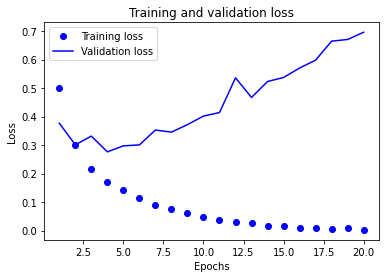

In [71]:
# Plotting the training and validation loss

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')  # “bo” is for “blue dot.”
plt.plot(epochs, val_loss_values, 'b', label='Validation loss') # “b” is for “solid blue line.”
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

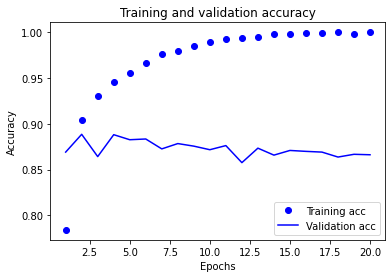

In [72]:
# Plotting the training and validation accuracy

plt.clf()
acc = history_dict['acc']
val_acc = history_dict['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

As you can see, the training loss decreases with every epoch, and the training accuracy increases with every epoch. That’s what you would expect when running gradient-descent optimization — the quantity you’re trying to minimize should be less with every iteration. But that isn’t the case for the validation loss and accuracy: they seem to peak at the fourth epoch. This is an example of what we warned against earlier: a model that performs better on the training data isn’t necessarily a model that will do better on data it has never seen before. In precise terms, what you’re seeing is ***overfitting***: after the fourth epoch, you’re over-optimizing on the training data, and you end up learning representations that are specific to the training data and don’t generalize to data outside of the training set.

In this case, to prevent overfitting, you could stop training after three epochs. In general, you can use a range of techniques to mitigate overfitting, which we’ll cover in chapter 4.

Let’s train a new model from scratch for four epochs and then evaluate it on the test data.

In [73]:
model = keras.Sequential([
    layers.Dense(16, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
49/49 [==============================] - 2s 23ms/step - loss: 0.5368 - accuracy: 0.7524
Epoch 2/4
49/49 [==============================] - 1s 23ms/step - loss: 0.2576 - accuracy: 0.9155
Epoch 3/4
49/49 [==============================] - 1s 22ms/step - loss: 0.1966 - accuracy: 0.9292
Epoch 4/4
782/782 [==============================] - 1s 2ms/step - loss: 0.3057 - accuracy: 0.8798


In [74]:
results

[0.30572283267974854, 0.8798400163650513]

This fairly naive approach achieves an accuracy of 88%. With state-of-the-art approaches, you should be able to get close to 95%.

### Using a trained model to generate predictions on new data

After having trained a model, you’ll want to use it in a practical setting. You can generate the likelihood of reviews being positive by using the ***predict*** method

In [76]:
# As you can see, the model is confident for some samples (0.99 or more, or 0.01 or less) but less confident for others (0.6, 0.4).
model.predict(x_test)

array([[0.24927855],
       [0.9998295 ],
       [0.9477451 ],
       ...,
       [0.18919235],
       [0.095815  ],
       [0.7352834 ]], dtype=float32)

#### Further experiments

The following experiments will help convince you that the architecture choices you’ve made are all fairly reasonable, although there’s still room for improvement:

You used two representation layers before the final classification layer. Try using one or three representation layers, and see how doing so affects validation and test accuracy.

Try using layers with more units or fewer units: 32 units, 64 units, and so on.

Try using the ***mse*** loss function instead of ***binary_crossentropy***.

Try using the ***tanh*** activation (an activation that was popular in the early days of neural networks) instead of ***relu***.

### Wrapping up

Here’s what you should take away from this example:

You usually need to do quite a bit of preprocessing on your raw data in order to be able to feed it — as tensors — into a neural network. Sequences of words can be encoded as binary vectors, but there are other encoding options, too.
Stacks of ***Dense*** layers with ***relu*** activations can solve a wide range of problems (including sentiment classification), and you’ll likely use them frequently.
In a binary classification problem (two output classes), your model should end with a ***Dense*** layer with one unit and a ***sigmoid*** activation: the output of your model should be a scalar between 0 and 1, encoding a probability.
With such a scalar sigmoid output on a binary classification problem, the loss function you should use is ***binary_crossentropy***.
The ***rmsprop*** optimizer is generally a good enough choice, whatever your problem. That’s one less thing for you to worry about.
As they get better on their training data, neural networks eventually start overfitting and end up obtaining increasingly worse results on data they’ve never seen before. Be sure to always monitor performance on data that is outside of the training set.